<a href="https://colab.research.google.com/github/agapiko/Early_Detection_Of_DIABETIC_RETINOPATHY/blob/main/CNN_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import numpy as np
import pandas as pd
import cv2
import os
import datetime
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tqdm import notebook
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from prettytable import PrettyTable
from sklearn.metrics import cohen_kappa_score
import time

In [37]:
IMG_SIZE = 256
BATCH_SIZE = 16

In [38]:
df = pd.read_csv('/content/drive/My Drive/labels.csv')

In [39]:
# Initial 70-30 split for train and temp (which includes validation + test)
x_train, x_temp, y_train, y_temp = train_test_split(
    df['id_code'], df['diagnosis'], test_size=0.30, stratify=df['diagnosis'], random_state=100
)

# Further split temp into 50-50 (15% validation, 15% test)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=100
)

# Reset indices for the splits
x_train = x_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Define the base path for images
base_image_path = '/content/drive/My Drive/train_images_ben_preprocessed_sigmaX10'

# Update x_train, x_val, and x_test with the full paths
x_train = x_train.apply(lambda i: os.path.join(base_image_path, f'{i}.png'))
x_val = x_val.apply(lambda i: os.path.join(base_image_path, f'{i}.png'))
x_test = x_test.apply(lambda i: os.path.join(base_image_path, f'{i}.png'))

In [40]:
import cv2
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

def process_image(path, img_size):
    img = cv2.imread(path)
    return cv2.resize(img, (img_size, img_size))

def load_images_parallel(image_paths, img_size, num_workers=4):
    images = np.empty((len(image_paths), img_size, img_size, 3), dtype='uint8')
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_image, path, img_size) for path in image_paths]
        for i, future in enumerate(tqdm(futures)):
            images[i] = future.result()
    return images

# Load train images
train_images = load_images_parallel(x_train, IMG_SIZE)

# Load validation images
val_images = load_images_parallel(x_val, IMG_SIZE)

# Load test images
test_images = load_images_parallel(x_test, IMG_SIZE)

100%|██████████| 550/550 [00:02<00:00, 209.64it/s]


In [41]:
# Convert y_train, y_val, and y_test to one-hot encoded format
y_train = pd.get_dummies(y_train).values
y_val = pd.get_dummies(y_val).values
y_test = pd.get_dummies(y_test).values

# Normalize the images to [0, 1] by dividing by 255.0
train_images = train_images.astype('float32') / 255.0
val_images = val_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [42]:
# Convert boolean labels to integers (0/1)
y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)

In [43]:
# Apply data augmentation and ensure the dataset repeats
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label


# Training dataset with augmentation, shuffling, batching, and prefetching
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(train_images))
train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, y_val)).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch for performance

In [44]:
class QWKCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, num_classes):
        super(QWKCallback, self).__init__()
        self.validation_data = validation_data
        self.num_classes = num_classes
        self.qwk_scores = []  # To store QWK scores for each epoch
        self.val_qwk_scores = []  # To store validation QWK scores
        self.best_qwk = -np.inf  # Track the best QWK score

    def on_epoch_end(self, epoch, logs=None):
        val_data, val_labels = self.validation_data
        val_pred = self.model.predict(val_data)

        try:
            val_pred_labels = np.argmax(val_pred, axis=1)
            val_true_labels = np.argmax(val_labels, axis=1)

            # Calculate QWK using sklearn's cohen_kappa_score
            qwk_score = cohen_kappa_score(val_true_labels, val_pred_labels, weights='quadratic')
            print(f" - val_qwk: {qwk_score:.4f}")

            # Store QWK scores for plotting later
            self.val_qwk_scores.append(qwk_score)

            # Track QWK in logs so it appears in history
            logs['val_qwk'] = qwk_score

            # Save the best QWK score
            if qwk_score > self.best_qwk:
              self.best_qwk = qwk_score
              print(f"Validation QWK improved to {qwk_score:.4f}, saving model.")
              self.model.save(f'/content/drive/My Drive/cnn_qwk_best_model_{round(self.best_qwk, 2)}.keras')

        except Exception as e:
            print(f"Error in QWK calculation: {e}")
            logs['val_qwk'] = 0  # Set QWK to 0 if there's an error

In [45]:
# CNN model

input1 = layers.Input((IMG_SIZE, IMG_SIZE, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(input1)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output1 = layers.Dense(5, activation='softmax')(x)

model1 = tf.keras.Model(inputs=input1, outputs=output1)

model1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 516128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │      16,516,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,517,189 (63.01 MB)

 Trainable params: 16,517,189 (63.01 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# Compile the model using categorical crossentropy (since labels are one-hot encoded)
model1.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

qwk_callback = QWKCallback(validation_data=(val_images, y_val), num_classes=5)

# Start time
start_time = time.time()

# Train the model
history = model1.fit(
    train_dataset,
    epochs=15,
    validation_data=val_dataset,
    callbacks=[qwk_callback]
)

# End time
end_time = time.time()

Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
 - val_qwk: 0.6656
Validation QWK improved to 0.6656, saving model.
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.5664 - loss: 3.8758 - val_accuracy: 0.7067 - val_loss: 0.8662 - val_qwk: 0.6656
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 - val_qwk: 0.7197
Validation QWK improved to 0.7197, saving model.
161/161 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - accuracy: 0.7150 - loss: 0.8419 - val_accuracy: 0.7158 - val_loss: 0.8260 - val_qwk: 0.7197
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 - val_qwk: 0.6816
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7059 - loss: 0.8083 - val_accuracy: 0.7140 - val_loss: 0.8455 - val_qwk: 0.6816
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
 - val_qwk: 0.7277
Validation QWK improved to 0.7277, saving model.
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7205 - loss: 0.7730 - val_accuracy: 0.7213 - val_loss: 0.7728 - val_qwk: 0.7277
Epoch 5/15
18/18 ━━━━━━━━━━━━━━

Text(0.5, 1.0, 'Training and Validation Accuracy')

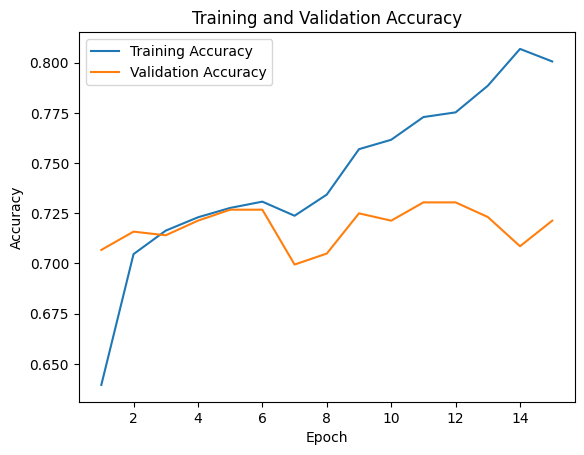

In [47]:
n_epochs = len(history.history['loss'])  # Total number of epochs
epochs_range = range(1, n_epochs + 1)

# Plot Accuracy
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Loss')

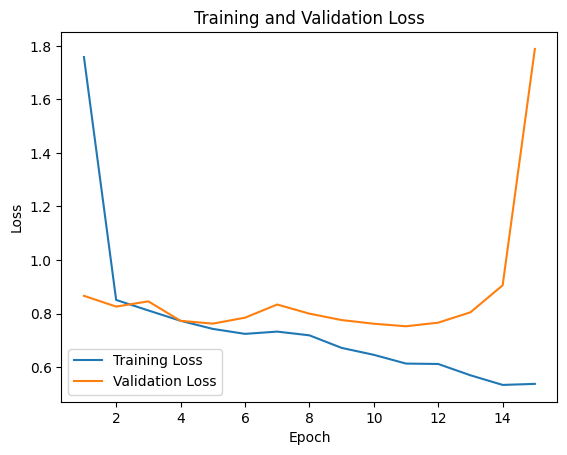

In [48]:
# Plot Loss
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

Text(0.5, 1.0, 'Validation QWK Score Per Epoch')

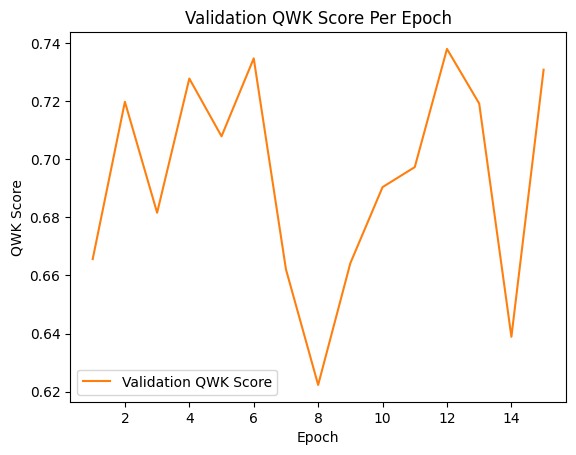

In [49]:
# Plot QWK (Quadratic Weighted Kappa) Score
plt.plot(epochs_range, history.history['val_qwk'], label='Validation QWK Score', color='#FF7F0E')
plt.xlabel('Epoch')
plt.ylabel('QWK Score')
plt.legend()
plt.title('Validation QWK Score Per Epoch')

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


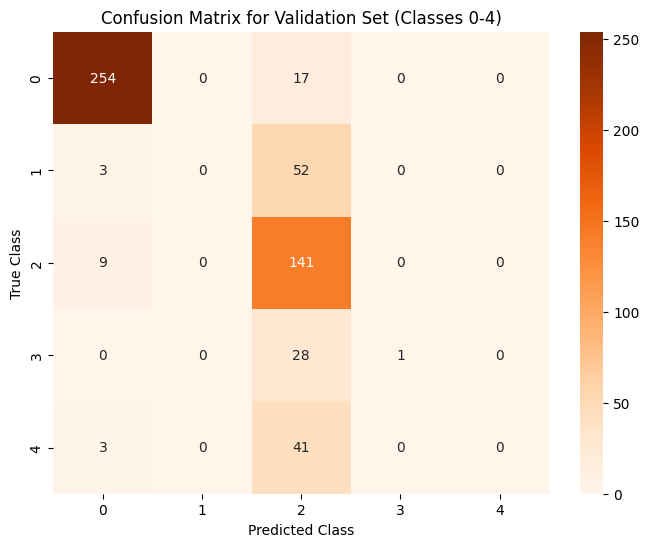

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Predict on validation dataset
val_predictions = model1.predict(val_images)
val_pred_labels = np.argmax(val_predictions, axis=1)  # Get the predicted class labels
val_true_labels = np.argmax(y_val, axis=1)  # Get the true class labels

# Generate confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_pred_labels, labels=[0, 1, 2, 3, 4])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix for Validation Set (Classes 0-4)')
plt.show()

## **Evaluation of CNN model**

In [58]:
# Test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch for better performance

In [59]:
# Predicting on the test set
test_predictions = model1.predict(test_dataset)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [60]:
# Convert probabilities to class labels
predicted_labels = np.argmax(test_predictions, axis=1)  # Index of the highest probability

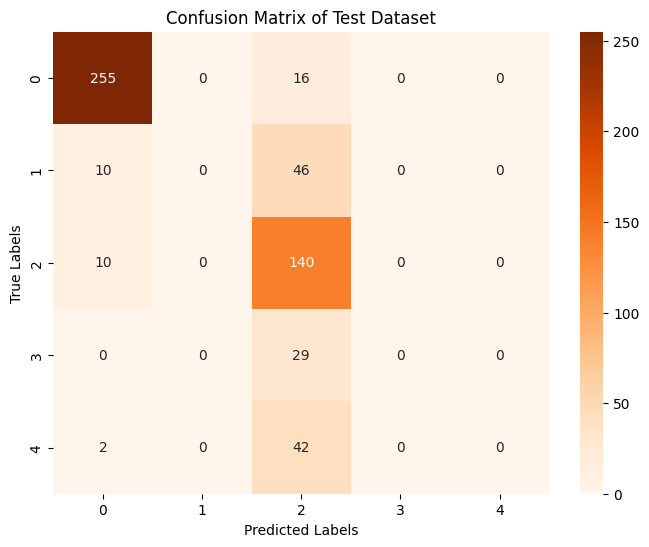

In [61]:
from sklearn.metrics import confusion_matrix

# True labels for the test set
true_labels = np.argmax(y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plotting the confusion matrix using Oranges color map
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Oranges", xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of Test Dataset')
plt.show()

In [62]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, confusion_matrix, cohen_kappa_score
import time

def evaluate_model(model, test_dataset, y_test):

    # Measure computational time for predictions
    test_predictions = model.predict(test_dataset)
    predicted_labels = np.argmax(test_predictions, axis=1)
    computation_time = end_time - start_time

    true_labels = np.argmax(y_test, axis=1)

    # Accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)

    # F1-Score (weighted average for multi-class)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Sensitivity (Recall) for the model (macro average)
    sensitivity = recall_score(true_labels, predicted_labels, average='macro')

    # Specificity manually
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    TN = conf_matrix.sum() - (conf_matrix.sum(axis=0) - np.diag(conf_matrix)).sum()  # True Negatives
    FP = (conf_matrix.sum(axis=0) - np.diag(conf_matrix)).sum()  # False Positives
    specificity = TN / (TN + FP)

    # AUC Score
    auc_score = roc_auc_score(y_test, test_predictions, multi_class="ovr")

    # Cohen's Kappa Score
    kappa = cohen_kappa_score(true_labels, predicted_labels, weights='quadratic')

    results = pd.DataFrame({
        'Metric': ['Accuracy', 'F1-Score', 'Sensitivity (Recall)', 'Specificity', 'AUC Score', 'Quadratic Weighted Kappa Score'],
        'Value': [accuracy, f1, sensitivity, specificity, auc_score, kappa]
    })

    return results

model_results = evaluate_model(model1, test_dataset, y_test)

# Calculate and print the time taken
training_time = end_time - start_time

print(model_results)
print(f"Total training time: {training_time:.2f} seconds")

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
                           Metric     Value
0                        Accuracy  0.718182
1                        F1-Score  0.639089
2            Sensitivity (Recall)  0.374859
3                     Specificity  0.718182
4                       AUC Score  0.787650
5  Quadratic Weighted Kappa Score  0.737871
Total training time: 48.44 seconds
